In [1]:
#!pip install xgboost #Does not exist in jupyter notebook

In [2]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import MaxAbsScaler, StandardScaler

#Import models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

In [3]:
#Load the data
filepath = r'C:\Users\ktsil\Desktop\DSBA\Courses\T2\Ensemble Learning\Project\Airbnb_price_prediction\airbnb_preprocessed.csv'
airbnb = pd.read_csv(filepath)

In [4]:
# Isolate the predicting features
X = airbnb.drop(['price'], axis=1)

# We will transform to logarithm and predict that
y = np.log(airbnb['price']+1)

In [5]:
#Perform a split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Initialize the StandardScaler object
scaler = StandardScaler()

# We will only transform continuous columns

# Select only columns with numeric types
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()

# Identify binary columns
binary_cols = []
for col in num_cols:
    if X[col].nunique() == 2:
        binary_cols.append(col)

# Identify continuous columns
continuous_cols = list(set(num_cols) - set(binary_cols))

# Scale the continuous columns, fitting them on the training set only
scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])

# Transform the test set using the same scaler parameters
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Combine the binary and continuous columns into a single dataframe
X_train_scaled = pd.concat([X_train[continuous_cols], X_train[binary_cols]], axis=1)
X_test_scaled = pd.concat([X_test[continuous_cols], X_test[binary_cols]], axis=1)

Now the data is final and will be used for modelling. All the models have already been optimized by using hyperparameter tuning. The best resulting parameters are the ones used here for the models to run.

In [7]:
# Define the function that performs predictions and prints the evaluation metrics
def predictions(model,X_train, X_test, y_train, y_test):
    
    # Fit the model on the train data
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    
    # Exponentiate predictions back to original scale
    y_pred_exp = np.exp(y_pred)-1
    
    # Evaluate the model using r2 score
    print('R2 score:', r2_score(y_test, y_pred))
    
    # Evaluate the model on RMSE
    # Train
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    print("RMSE train:", rmse_train)
    # Test
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)
    print("RMSE test:", rmse_test)
    
    #Compute RMSEwith original values
    mse = mean_squared_error(np.exp(y_test)-1, y_pred_exp) #Transform back to original price
    rmse = np.sqrt(mse)
    print("RMSE test after tranforming back to original:", rmse)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Evaluate predictions graphically (this is the log)
    sns.regplot(y=y_test, x=y_pred, color='lightblue', ax=axes[0])
    axes[0].set_title('Evaluated predictions (log scale)')
    axes[0].set_xlabel('Predictions')
    axes[0].set_ylabel('Real values')
    
    # Visualize feature importance
    if type(model) == BaggingRegressor:
        return "Feature importance cannot be printed for bagging"

    # Get feature importance for other models
    importances = model.feature_importances_
        
    # Sort features by importance
    indices = np.argsort(importances)[::-1]
    features_sorted = [X_train.columns[i] for i in indices]

    # Plot feature importances
    axes[1].set_title("Feature Importances")
    axes[1].bar(range(X_train.shape[1]), importances[indices])
    axes[1].set_xticks(range(X_train.shape[1]))
    axes[1].set_xticklabels(features_sorted, rotation=90)

    plt.show()

## Decision Trees

R2 score: 0.5544606573300714
RMSE train: 0.43476613532397146
RMSE test: 0.45888339350712004
RMSE test after tranforming back to original: 182.01447470543124


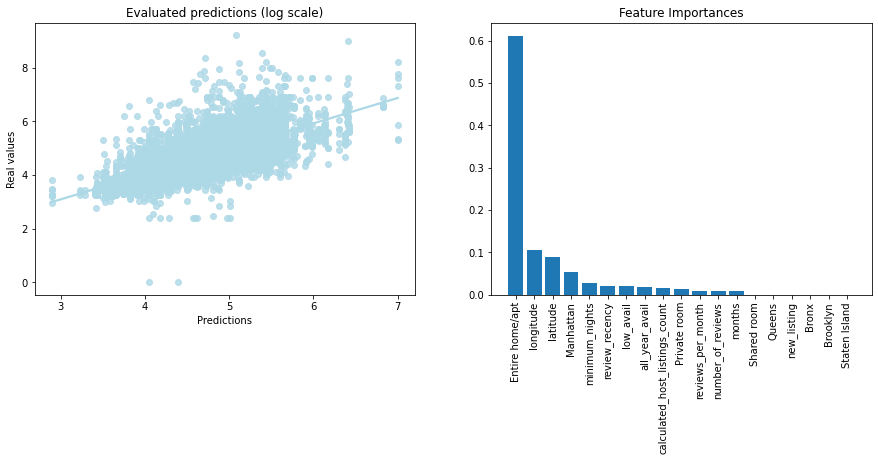

In [8]:
#Initialize model
DTree = DecisionTreeRegressor(random_state = 42, criterion= 'squared_error', max_depth = 10,
                              max_features = None, max_leaf_nodes = None, min_samples_leaf = 10,
                              min_samples_split = 6, splitter = 'best')

predictions(DTree, X_train_scaled, X_test_scaled, y_train, y_test)

## Bagging

R2 score: 0.6078005976056986
RMSE train: 0.20435021898823935
RMSE test: 0.4305392750788232
RMSE test after tranforming back to original: 177.19977727190033


'Feature importance cannot be printed for bagging'

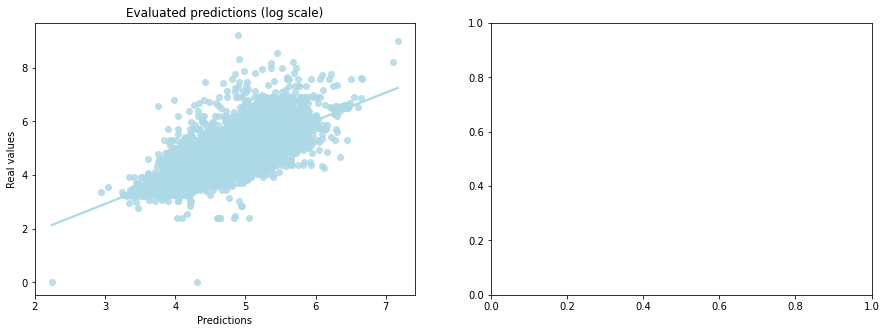

In [9]:
# Initialize model
BR = BaggingRegressor(n_estimators = 150, max_features= 0.8, max_samples = 0.8)

predictions(BR, X_train_scaled, X_test_scaled, y_train, y_test)

## Random Forest

R2 score: 0.5998212416939606
RMSE train: 0.3029166131727351
RMSE test: 0.43489691566444777
RMSE test after tranforming back to original: 179.18586582161916


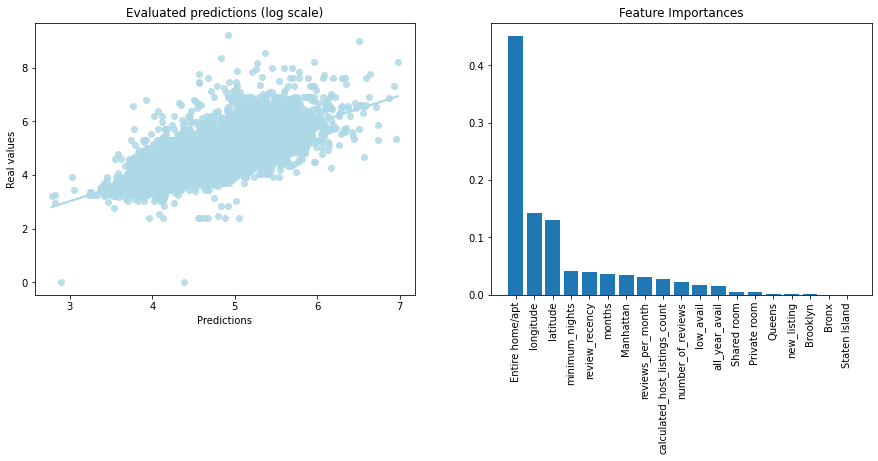

In [10]:
RF = RandomForestRegressor(max_depth=100 , min_samples_leaf= 4, min_samples_split= 2)

predictions(RF, X_train_scaled, X_test_scaled, y_train, y_test)

## Extremely Random Forest

R2 score: 0.5796595085362133
RMSE train: 0.4422309739069275
RMSE test: 0.44571774565297984
RMSE test after tranforming back to original: 183.4974126218763


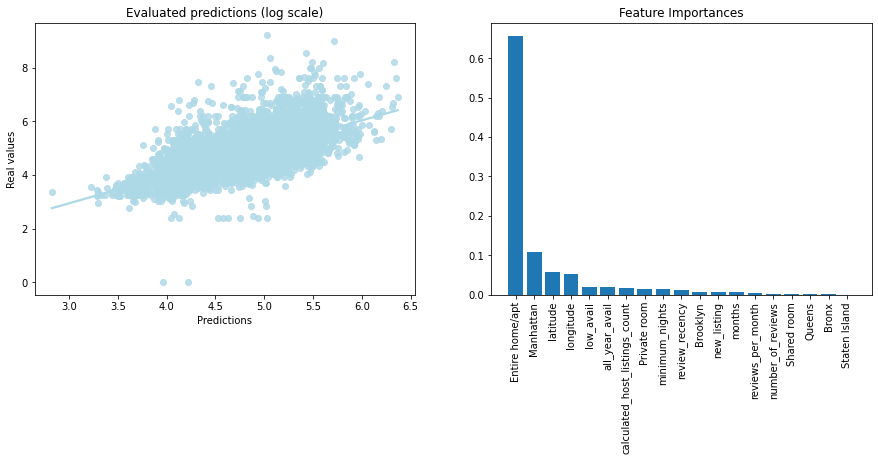

In [11]:
ETR = ExtraTreesRegressor(max_depth=10 , min_samples_leaf= 4, min_samples_split=6)

predictions(ETR, X_train_scaled, X_test_scaled, y_train, y_test)

## AdaBoost

R2 score: 0.5967710509873378
RMSE train: 0.37023071742271024
RMSE test: 0.4365511768990877
RMSE test after tranforming back to original: 179.42888078035455


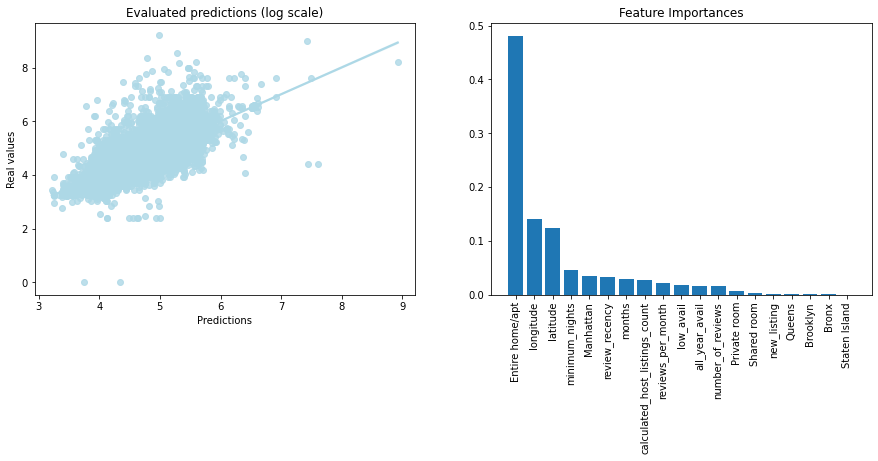

In [12]:
AdaBoost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=12), n_estimators=100, learning_rate=0.01, random_state=1234)

predictions(AdaBoost, X_train_scaled, X_test_scaled, y_train, y_test)

## Gradient Boosting

R2 score: 0.6094275835541496
RMSE train: 0.4021828234674546
RMSE test: 0.4296453301617763
RMSE test after tranforming back to original: 177.14607914863066


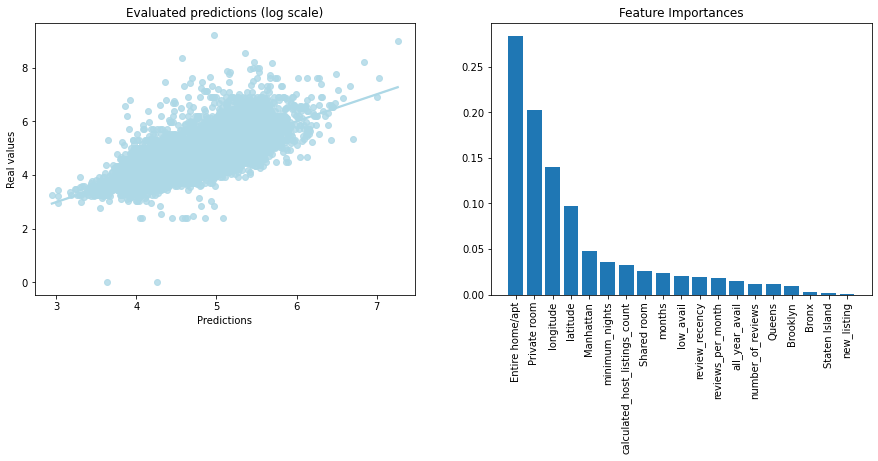

In [13]:
GBoost = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=6,
                                   max_features=0.3, min_samples_leaf=4, min_samples_split=6)

predictions(GBoost, X_train_scaled, X_test_scaled, y_train, y_test)

## XGBoost

R2 score: 0.6108234477747507
RMSE train: 0.3699276209038842
RMSE test: 0.42887688963960113
RMSE test after tranforming back to original: 175.10100167636276


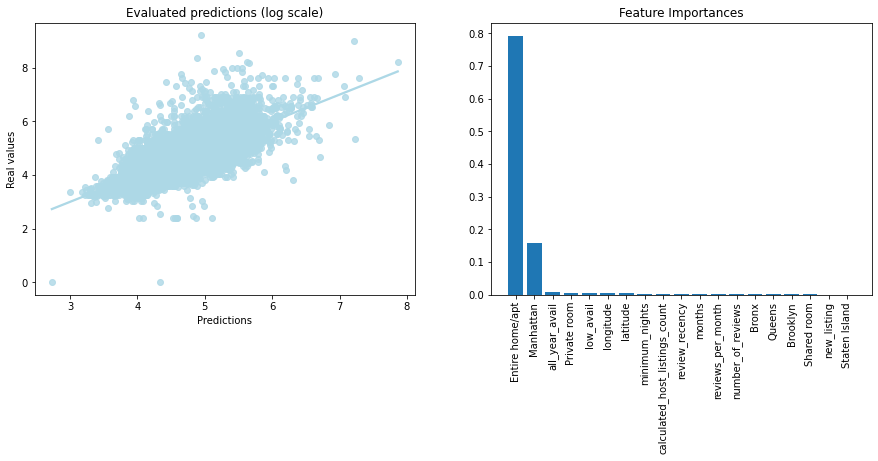

In [14]:
xgb_R = XGBRegressor(n_estimators=90, learning_rate=0.1, max_depth=10, min_child_weight=5, gamma=0.7)

predictions(xgb_R, X_train_scaled, X_test_scaled, y_train, y_test)